# Convolutions (and convolutional networks)

## Before Deep Learning era

Convolution is a well-known mathematical operator that has a lot of applications.

### Example: [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator)

**[Edge detection](https://en.wikipedia.org/wiki/Edge_detection)** --- the task of identifying edges on the image, defined as curves at which the image brightness changes sharply.

Approximate *image derivatives* along $x$ and $y$:

$ \mathbf{G}_x = \begin{bmatrix}
+1 & 0 & -1  \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{bmatrix} * \mathbf{A}
\quad
\mbox{and}
\quad   
\mathbf{G}_y = \begin{bmatrix}
+1 & +2 & +1\\
 0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix} * \mathbf{A} $,
where $\mathbf{A}$ denotes an image, and $*$ denotes convolution.

Resulting gradient magnitudes: $\mathbf{G} = \sqrt{ {\mathbf{G}_x}^2 + {\mathbf{G}_y}^2 }$

Let's plot them:

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f0/Valve_original_%281%29.PNG" width="300">
<img src="https://upload.wikimedia.org/wikipedia/commons/d/d4/Valve_sobel_%283%29.PNG" width="300">

Convolution with human-engineered kernel helped us to extract meaningful features from the image.

### And what about CNNs?

Deep Learning automates the feature extraction: now convolutional kernel is  *trainable*.

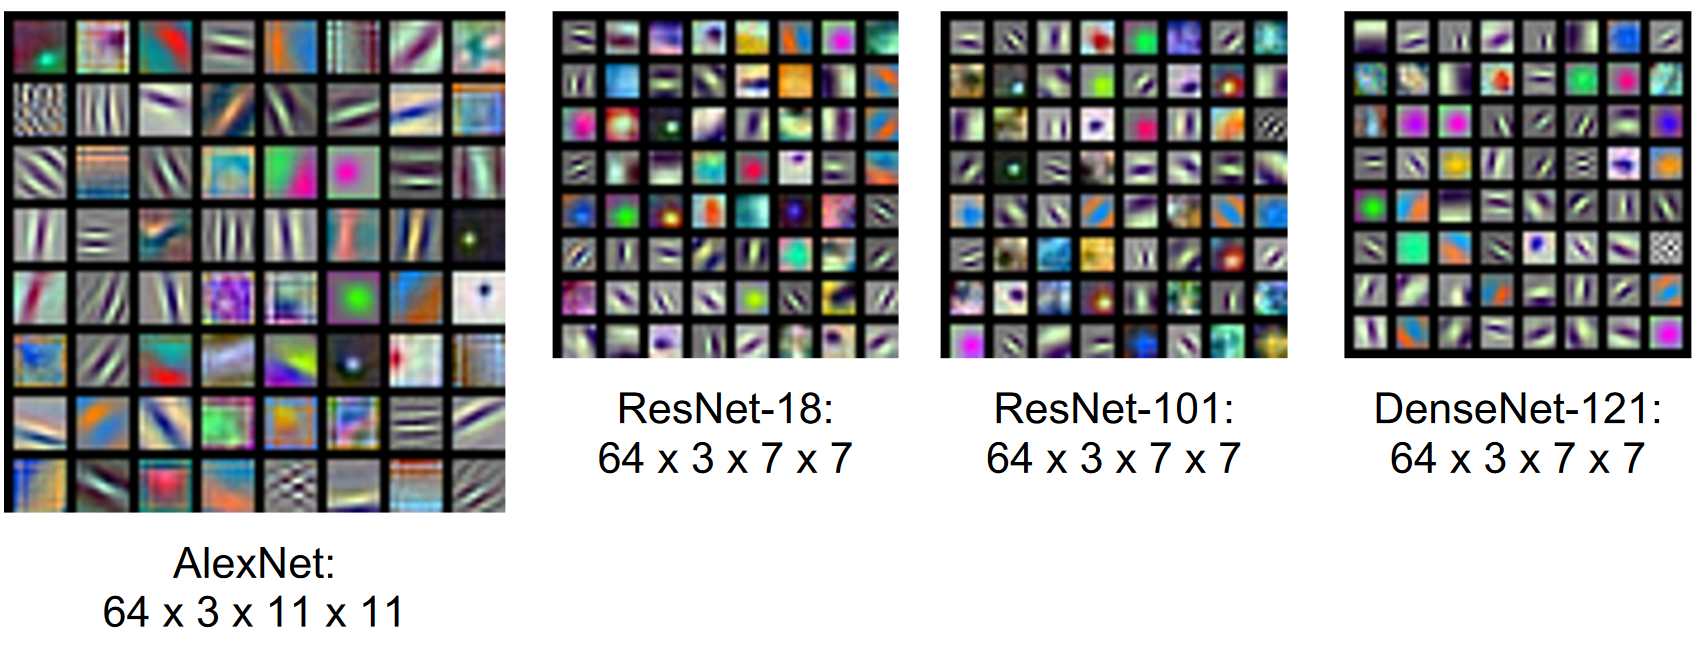

Source: http://cs231n.stanford.edu/slides/2022/lecture_8_ruohan.pdf

These filters not only remind us human-engineered filters (designed for the detection of edges, lines, blobs, ...), but also are very similar to the structure of a real biological vision systems (these patterns cause the highest activations of first layer of vision neurons).

Next layers correspond to more high-level features (and they are *much* harder to interpret).

## Convolutional architectures

In the next lecture you'll know about the development of convolutional architectures through the years. But now we'll practice to write the most basic ones.

We already know:

* Convolution
* Normalization (e.g., BatchNorm)
* Activations (e.g., ReLU)
* Pooling

### What does the typical CNN architecture look like?

`BLOCK = CONV -> NORM -> ACTIVATION`\
The simplest CNNs building block. As we'll see later, other building blocks exist (InceptionNet, ResNet, MobileNet, ...).

`STAGE = [CONV -> NORM -> ACTIVATION]*N -> POOLING?`\
The sequence of blocks operating with the same spatial resolution is often called a stage. To decrease the resolution, we may use pooling or stride=2 in convolution.

`HEAD = [FC -> ACTIVATION]*K -> FC` \
The part of the network that transforms extracted visual features into prediction (e.g., logits for classification) is called a head.

`INPUT -> STAGE*M -> GLOBAL_POOLING? -> HEAD`

In details:

* INPUT. As we decrease the spacial resolution throughout the network, width and height should be divisible by 2 to some power. The popular dimensions are 32 (CIFAR-10), 224 (ImageNet), and 512.
* CONV. It is recommended to use smaller kernel sizes (3х3 or 5х5). If you need larger receptive field, it is recommended to stack multiple kernels of small size than to use one of big size (*why?*).

  BUT: convolution with large kernel is often used as a first layer (that takes image as input) to significantly reduce spacial dimension.\
  (**Q:** What is the intuition behind that?)

  Usually padding is set to $p=(k−1)/2$ to preserve spacial resolution. Networks with padding usually work better, because information near the edges is preserved better.
* NORM. Batch Normalization is the industry standard, with some exceptions (e.g., InstanceNorm is often used in style transfer, Transformer employ LayerNorm, and some GANs require the absence of normalization).
* ACTIVATION. ReLU is old but good, its modifications like Leaky ReLU and other can increase the metrics and are often used in modern networks.
* POOLING (average or maximum). Decreases the spatial resolution of the feature map. Almost always poolings have 2x2 kernel and stride 2.

  Pooling causes the loss of information, so CNNs use convolutions with stride > 1 (see ResNet and later) instead of pooling.
* GLOBAL_POOLING.

  There are two ways of transition from the convolutional part to the fully connected head.

  The first is flattening of the tensor and treating it as 1D feature tensor. But for bigger networks the parameter count is large (for example, the first linear layer of VGG projects from 25088 features to 4096).

  The second is global pooling, a variant of pooling that has fixed output spatial resolution (usually 1x1). Even though intuitively we lose information at pooling layer, getting rid of it not only speeds up the network, but also reduces overfitting.

# How to train your ConvNet

## Training code

In [1]:
%load_ext tensorboard

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### Data loading

In [3]:
BATCH_SIZE = 32
N_CLASSES=10

MNIST is a very easy dataset, even simple network achieves 98%+ accuracy.

*(you can try it yourself)*

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

valid_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    drop_last=False,
    shuffle=False
)

So let's take CIFAR-10.

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

valid_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    drop_last=False,
    shuffle=False,
    num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified



**Answer the questions:**

**Q:** Why is `shuffle=True` in `train_loader`? Why is it `False` in `test_loader`?\
**A:** In train_loader shuffle=True because we don't want the model to rely on data order. In test_loader order of samples won't change the results.

**Q:** What about `drop_last`?\
**A:** If drop_last=True then we throw away the last incomplete batch.

**Q:** How input data normalization helps?\
**A:** Numerical stability, reduces the chances of overfitting, converges faster.


### Training

You learned about PyTorch Lighting on the last seminar. Let's use it to ease the pain.

As a bonus, we'll learn how to add metrics computation using `torchmetrics` ([link](https://lightning.ai/docs/torchmetrics/)).

In [6]:
!pip install -qq lightning torchinfo

In [14]:
import torch
import lightning
import torchmetrics
from lightning.pytorch.loggers import TensorBoardLogger


class LitClassifier(lightning.LightningModule):
    def __init__(self, model, num_classes):
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()

        self.train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)
        self.valid_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        # how to process batch of data during training
        inputs, targets = batch

        # Forward pass
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        self.log("train_loss", loss, on_step=True, on_epoch=False)

        # to compute the metric automatically, just call the object
        # state will be saved inside train_acc object
        self.train_acc(outputs, targets)
        # pass the metric object to the logger, Lightning will take care of
        # logging and resetting the metric automatically
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=False)

        # you don't even need to do backward and optimizer.step manually
        # just return the loss
        return loss

    def validation_step(self, batch, batch_idx):
        # how to process batch of data during validation
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        self.valid_acc(outputs, targets)
        self.log('valid_acc', self.valid_acc, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=0.001)
        return optimizer

## LeNet-5 (Yann LeCun, 1998)

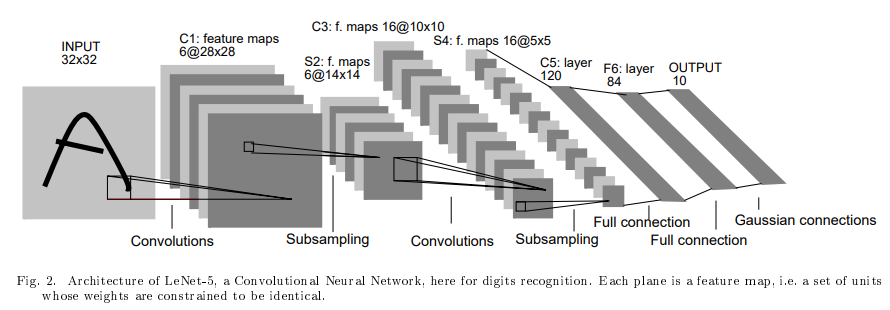

First practically feasible ConvNet. Some architectural decisions


**TASK 1:** Taking the inspiration from LeNet, write a simple small convolutional architecture and train it on CIFAR-10.

In [15]:
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
class SmallConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional part
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(num_features=6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # 6x14x14
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # 16x5x5
    
        # linear layers
        self.linear = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.linear(x)
        
        return x


model = SmallConvNet()
print(model)

SmallConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [16]:
lit_model = LitClassifier(model, N_CLASSES)
logger = TensorBoardLogger("tb_logs", name="small_conv_net")
trainer = lightning.Trainer(logger=logger, max_epochs=30)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | SmallConvNet       | 62.1 K
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | valid_acc | MulticlassAccuracy | 0     
-------------------------------------------------
62.1 K    Trainable params
0         Non-trainable params
62.1 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/home/semyon/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [13]:
%tensorboard --logdir tb_logs

Reusing TensorBoard on port 6006 (pid 19147), started 0:02:25 ago. (Use '!kill 19147' to kill it.)

## VGG (2014)

Visual Geometry Group from Oxford, 2014.

<img src="https://production-media.paperswithcode.com/methods/vgg_7mT4DML.png">

The network is entirely composed from 3x3 convolutions and ReLU's
(*except for the 1st convolution and final classification head*).

In [9]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super().__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

model = VGG('VGG11')

In [10]:
lit_model = LitClassifier(model, N_CLASSES)
trainer = lightning.Trainer(max_epochs=30)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | VGG                | 9.2 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | valid_acc | MulticlassAccuracy | 0     
-------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.924    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [29]:
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6011 (pid 27508), started 0:00:02 ago. (Use '!kill 27508' to kill it.)

## ResNet (2017)

Traditional networks have a problem: with the increase of depth, quality stops to increase and starts to decrease. It is related to vanishing gradient problem: in chain rule, gradients of different layers multiply, and multiplication of many values smaller than 1 gives *very small* number, and network refuses to fit with such small gradients.

The solution is *skip connections*. They throw gradients to the next layers without the change.

<img src="https://production-media.paperswithcode.com/methods/resnet-e1548261477164.png" width=500px>

In [11]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Identity()
        # How to do shortcuts?
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Identity
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet-18
model = ResNet(BasicBlock, [2, 2, 2, 2], N_CLASSES)

In [12]:
lit_model = LitClassifier(model, N_CLASSES)
trainer = lightning.Trainer(max_epochs=30)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | valid_acc | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.699    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

## Making convolutions lighter

Remember the lecture.
For mobile applications, standard convolutions may be too big.

#### Separable convolutions

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-31_at_10.30.20_PM.png" width=400px>

These convolutions are used in popular family of MobileNet models (v1, v2, v3) and their successors (EfficientNet, ...).

MobileNet v1 and v2 blocks:

<img src="https://machinethink.net/images/mobilenet-v2/DepthwiseSeparableConvolution@2x.png" height=400px>      <img src="https://machinethink.net/images/mobilenet-v2/ResidualBlock@2x.png" height=400px>

#### Why do we need 1x1 convolutions?
<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*dNaikOfrGzUaJ2EzRIl4tw.png" width=400px>

(https://medium.com/analytics-vidhya/talented-mr-1x1-comprehensive-look-at-1x1-convolution-in-deep-learning-f6b355825578)

In [13]:
import torchinfo
import torch
import torch.nn as nn

In [14]:
input = torch.rand((1, 128, 112, 112))

In [15]:
conv_standard = nn.Conv2d(128, 256, 3, 1, 1, bias=False)
torchinfo.summary(conv_standard, input_data=input)

Layer (type:depth-idx)                   Output Shape              Param #
Conv2d                                   [1, 256, 112, 112]        294,912
Total params: 294,912
Trainable params: 294,912
Non-trainable params: 0
Total mult-adds (G): 3.70
Input size (MB): 6.42
Forward/backward pass size (MB): 25.69
Params size (MB): 1.18
Estimated Total Size (MB): 33.29

In [17]:
conv_separable = nn.Sequential(
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, groups=128),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1)
)

torchinfo.summary(conv_separable, input_data=input)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 256, 112, 112]        --
├─Conv2d: 1-1                            [1, 128, 112, 112]        1,280
├─Conv2d: 1-2                            [1, 256, 112, 112]        33,024
Total params: 34,304
Trainable params: 34,304
Non-trainable params: 0
Total mult-adds (M): 430.31
Input size (MB): 6.42
Forward/backward pass size (MB): 38.54
Params size (MB): 0.14
Estimated Total Size (MB): 45.09

**TASK 2 (BONUS)**
Implement simple CNN architecture (e.g. the one we've used on the seminar) with lightweight separable convolutions.

Compare the accuracy and model size/inference speed.

Look into the article about some lightweight network (e.g., MobileNet) and traditional one (e.g., ResNet) and compare the quality and size/speed on real-world (not toy) networks.

In [33]:
class SepConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.sep_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, stride=stride, padding=1, kernel_size=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6()
        )

    def forward(self, x):
        out = self.sep_conv(x)
        
        return out



class SimpleSeparableConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            SepConv2d(3, 24),
            nn.MaxPool2d(2, 2),
            SepConv2d(24, 48),
            nn.MaxPool2d(2, 2),
            SepConv2d(48, 48),
            nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(
            nn.Linear(4*4*48, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.linear(x)

        return x



model = SimpleSeparableConvNet()

In [34]:
lit_model = LitClassifier(model, N_CLASSES)
trainer = lightning.Trainer(max_epochs=30)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | SimpleSeparableConvNet | 108 K 
1 | criterion | CrossEntropyLoss       | 0     
2 | train_acc | MulticlassAccuracy     | 0     
3 | valid_acc | MulticlassAccuracy     | 0     
-----------------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.432     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/semyon/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


**About big networks(on ImageNet):**
1) MobileNet v1
- 70.6 Accuracy
- 569 Million Mult-Adds
- 4.2 Million Parameters

2) ResNet-101
- 78 Accuracy
- 7600 Million Mult-Adds
- 44.6 Million Parameters

It is clear that MobileNet architecture cannot achieve the same quality as ResNet. 

However, due to its lightness and high speed this architecture works great for portable devices and does not suffer much in quality.

## Augmentations

Real-world datasets are often limited. Data augmentation is the process of creating new training samples from existing ones.

This additional data helps to
1. Improve model performance
(because model will see variations of existing data, practically having larger dataset)
2. Reduce the amount of labelled data needed
(because we can increase the effective size of dataset)
3. Mitigate overfitting in training data
(because it is harder to overfit on the larger dataset)

Data augmentations are available in [torchvision](https://pytorch.org/vision/stable/transforms.html).

The recommended library, though, is [albumentations.ai](https://albumentations.ai/).

More advanced augmentations like CutMix, Mixup - wait for Seminar 13.

<img src="https://camo.githubusercontent.com/0a0cea2503f569ac965d9de888206b482d13ffe751c682638c730296a352e1ba/68747470733a2f2f686162726173746f726167652e6f72672f776562742f62642f6e652f72762f62646e6572763563746b75646d73617a6e687734637273646669772e6a706567" width=600px>

**TASK 3 (BONUS)**
Write a simple augmentation strategy for CIFAR-10 images. Train the network from the seminar and compare the metrics.

In [43]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class CIFAR10(torch.utils.data.Dataset):
#     def __init__(self, root, train=True, transform=None):
#         self.root = root
#         self.train = train
#         self.transform = transform
#         self.dataset = torchvision.datasets.CIFAR10(root=self.root, train=self.train, download=True)

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         image, label = self.dataset[idx]
        
#         if self.transform:
#             augmented = self.transform(image=image)
#             image = augmented['image']
        
#         return image, label




# train_transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
#     A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#     ToTensorV2()
# ])

# train_dataset = CIFAR10(
#     root='./data',
#     train=True,
#     transform=train_transform
# )

# train_loader = torch.utils.data.DataLoader(
#     dataset=train_dataset,
#     batch_size=BATCH_SIZE,
#     drop_last=True,
#     shuffle=True,
#     num_workers=2
# )

**Note:**
I tried to use the albumentataions library but always got an error 

'/lib/python3.10/site-packages/albumentations/core/composition.py", line 282, in _check_args
    raise TypeError(f"{data_name} must be numpy array type")
TypeError: image must be numpy array type'

So i just gave up :(

In [46]:
train_transform = transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=train_transform
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
    num_workers=2
)

In [47]:
model = SmallConvNet()
lit_model = LitClassifier(model, N_CLASSES)
logger = TensorBoardLogger("tb_logs", name="small_conv_net")
trainer = lightning.Trainer(logger=logger, max_epochs=30)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | SmallConvNet       | 62.1 K
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | valid_acc | MulticlassAccuracy | 0     
-------------------------------------------------
62.1 K    Trainable params
0         Non-trainable params
62.1 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/home/semyon/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## How to increase quality?

1. Augmentations
2. STACK MOAR LAYERS

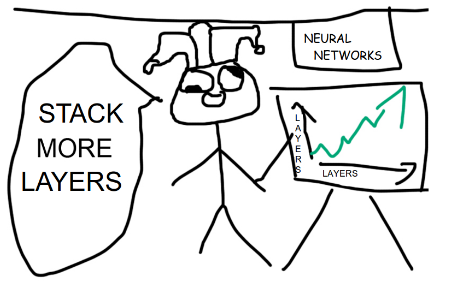

3. Advanced building blocks, advanced architectures, better optimizer, regularization
4. Transfer Learning
5. Self-supervised learning, neural architecture search, ...

## A ConvNet for the 2020s

[arXiv](https://arxiv.org/abs/2201.03545)

With the emergence of Visual Transformers, the question arose: are convolutional networks still relevant, or should they be left in the past?

It turns out that if you take ResNet-50 from 2017 and apply the same tricks used for training new networks, it shows comparable quality!


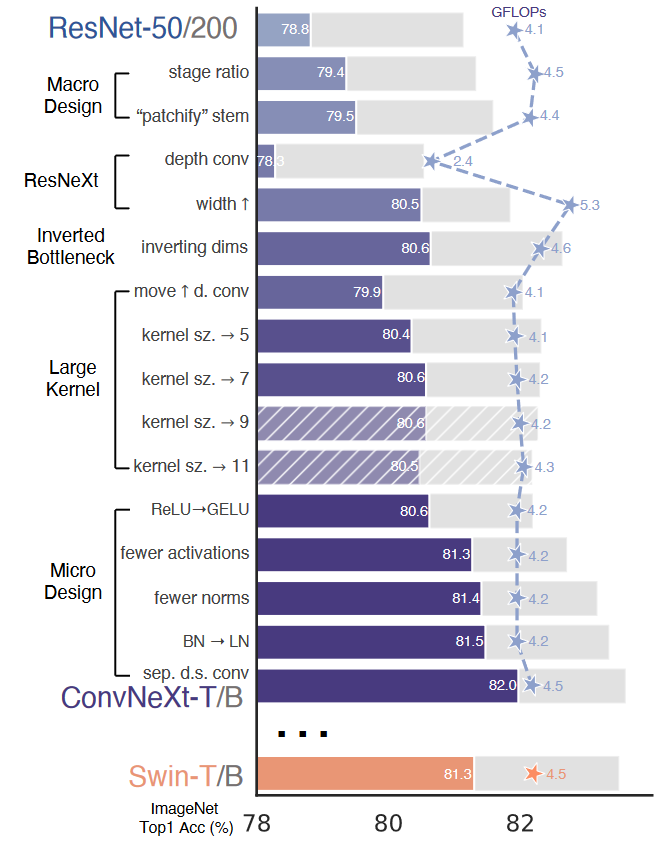

## Additional materials
https://cs231n.github.io/convolutional-networks/
